In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import sys
sys.path.append('../../')

import datetime
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator_rec import MeshDiffuser
from optimizer import Annealing, AnnealingSolver, PolyTop, AnnealingParameterTuning

# Parameter Tuning for Diffuser problem

## Computational Mesh

In [2]:
# Create Meshes for Diffuser Problem
n_elem_for_width = 32
n_elem_for_height = 32

mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model

### Boundary Conditions

In [3]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
# Compute boundary velocities.
width =1/3
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

# Pressure.
BC = []
for boundary in mesh_p.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_p.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall':
            pass
boundary_values_p= np.array(BC)

### Material Properties

In [5]:
viscosity = 1.0; 
density = 1

### Finite Element Model

In [6]:
fem = FEM(mesh_v, mesh_p, viscosity, density)
fem.set_boudary_values_v(boundary_values_v)

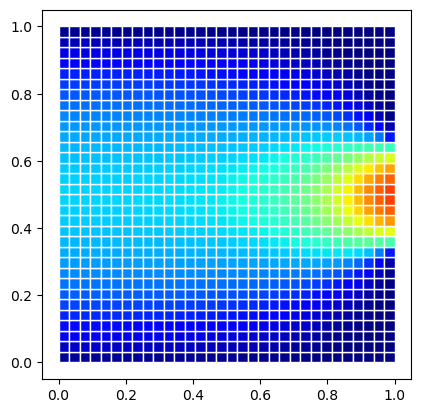

In [7]:
U, u_e, v_e, p_e, F, f=fem.solve()
coords, elements, boundary_nodes, neighbor_elements=mesh_p.create_mesh_Q1(n_elem_for_width, n_elem_for_height, 1., 1.)
from flow_solver import Q2Q1FEM
Q2Q1FEM.Plot_patch(n_elem_for_width,coords,elements,np.sqrt(u_e**2+v_e**2),3.,0,cmap='jet')

In [8]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.

density_initial_QA = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0
density_max = 1.0 # Lower and upper bound for design variables.

## Optimization with Annealing

In [9]:
from amplify.client import FixstarsClient
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True
client.token = 'AE/tAR7MLHq3WTe0DSGFyDWdcwHm4eKoIxN '
#client.proxy = ''

annealing_solver = AnnealingSolver(client)

In [10]:
iterations = 10
char = 25.
vol = 160.

In [11]:
dis_d = 0.2
reg_d = 0.4

In [12]:
result_dir = 'figdata_'+datetime.datetime.now().strftime('%Y%m%d%H%M%S')
os.mkdir(result_dir)

In [ ]:
obj_list = []
frac_list = []
test_list = []
for dis_num in range(10):
    dis = dis_d * dis_num
    for reg_num in range(11):
        reg = reg_d * reg_num
        annealing_optimizer = AnnealingParameterTuning(fem)
        obj, frac, test = annealing_optimizer.optimize_tuning(annealing_solver, density_initial_QA, 
                                density_min, density_max, volume_fraction_max, dis, reg, 
                                char, vol, iterations, result_dir)
        obj_list.append(obj)
        frac_list.append(frac)
        test_list.append(test)

In [ ]:
eloss = np.array(obj_list)
ax = plt.axes()
plt.imshow(eloss.reshape((10,11)),cmap='jet',vmax =14.9)
ax=plt.gca()
ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-.5, 11, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)
plt.colorbar()
plt.tick_params(bottom=False,left=False,right=False,top=False)
plt.show()

In [ ]:
vfrac = np.array(frac_list)
ax = plt.axes()
plt.imshow(vfrac.reshape((10,11)),cmap='jet',vmax =14.9)
ax=plt.gca()
ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-.5, 11, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)
plt.colorbar()
plt.tick_params(bottom=False,left=False,right=False,top=False)
plt.show()

In [ ]:
heav_err = np.array(test_list)
ax = plt.axes()
plt.imshow(heav_err.reshape((10,11)),cmap='jet',vmax =14.9)
ax=plt.gca()
ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-.5, 11, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)
plt.colorbar()
plt.tick_params(bottom=False,left=False,right=False,top=False)
plt.show()

In [ ]:
fig, axs = plt.subplots(10, 11, figsize=(15, 15))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for dis_num in range(10):
    dis = dis_d * dis_num
    for reg_num in range(11):
        reg = reg_d * reg_num
        img = np.load(result_dir+f'/array_el_{dis}_ge_{reg}_hev_{char}_dc_{vol}.npy')
        axs[dis_num][reg_num].imshow(img.reshape(32,32).T,cmap='gray')
        axs[dis_num][reg_num].tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        axs[dis_num][reg_num].tick_params(bottom=False,left=False,right=False,top=False)
        axs[dis_num][reg_num].spines['right'].set_visible(False)
        axs[dis_num][reg_num].spines['top'].set_visible(False)
        axs[dis_num][reg_num].spines['bottom'].set_visible(False)
        axs[dis_num][reg_num].spines['left'].set_visible(False)
plt.show()